Original class distribution:
Label
BENIGN              2096484
DoS Hulk             172849
DDoS                 128016
PortScan              90819
DoS GoldenEye         10286
FTP-Patator            5933
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Bot                    1953
Brute Force            1470
XSS                     652
Infiltration             36
Sql Injection            21
Heartbleed               11
Name: count, dtype: int64

After removing minority classes (min_samples=1000):
Label
BENIGN              2096484
DoS Hulk             172849
DDoS                 128016
PortScan              90819
DoS GoldenEye         10286
FTP-Patator            5933
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Bot                    1953
Brute Force            1470
Name: count, dtype: int64
New class distribution:
 Label
5     172849
3     128016
0     100000
9      90819
4      10286
8       5933
7       5385
6   

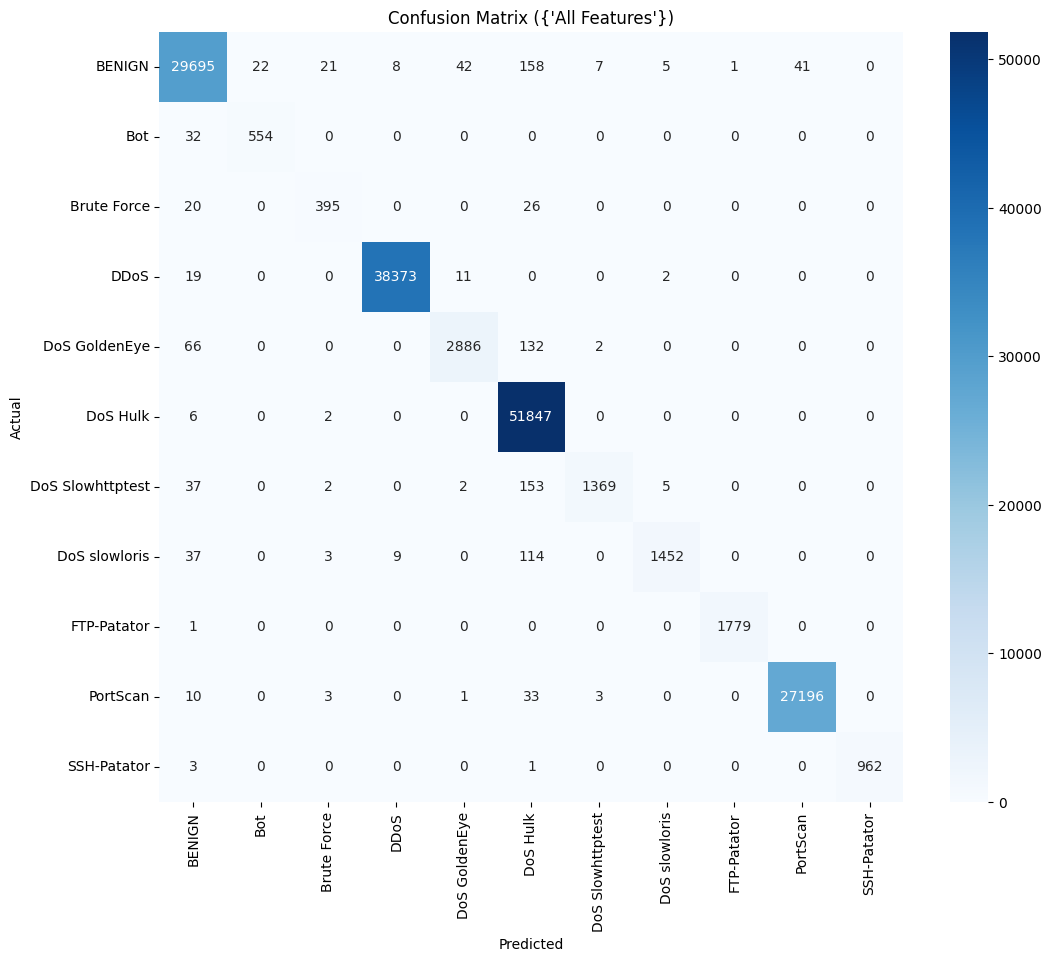

In [ ]:
import xgboost as xgb
import pandas as pd
import time
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')


sys.path.append('/home/ibibers/XAI_Evalation_For_IDS_datasets/Datasets_prepration')
from CICIDS2017 import data_preprocessing, evaluate_model, plot_confusion_matrix

le, X, y, X_train, X_test, y_train, y_test, df  = data_preprocessing()
import time
start_total_time = time.time()
xgb_model = xgb.XGBClassifier(random_state=42, learning_rate=0.001, objective='multi:softmax')

start_train_time = time.time()
xgb_model.fit(X_train, y_train)
end_train_time = time.time()
start_pred_time = time.time()
y_pred_encoded_class = xgb_model.predict(X_test)
end_pred_time = time.time()
end_total_time = time.time()

total_time = end_total_time - start_total_time
training_time = end_train_time - start_train_time
prediction_time = end_pred_time - start_pred_time

print("Number of samples before training:", len(X_train))
print(f"Total time: {total_time} seconds")
print(f"Training time: {training_time} seconds")
print(f"Prediction time: {prediction_time} seconds")

y_pred_class = le.inverse_transform(y_pred_encoded_class)
y_test_labels = le.inverse_transform(y_test)

metrics = evaluate_model(y_test_labels, y_pred_class, f" XGBoost ({{'All Features'}})")

plot_confusion_matrix(y_test_labels, y_pred_class, le.classes_, f"Confusion Matrix ({{'All Features'}})")
# ----------------------------- XAI methods --------------------------------

sys.path.append('/home/ibibers/XAI_Evalation_For_IDS_datasets/XAI_Methods')
from SHAP import explain_with_shap
from LIME import explain_with_lime

shap_values, Shap_explainer = explain_with_shap(xgb_model, X_train, X_test, model_type=None, num_samples=5000)



lime_explianer, Lime_exp_Inst = explain_with_lime(
    model=xgb_model,
    X_train=X_train,
    X_test=X_test,
    mode='classification',
    num_features=77,
    num_samples=5000,      
    kernel_width=None,     
    random_state=42,        
    discretize_continuous=True,
    return_instance_exp=True
)



In [2]:
print("SHAP values shape:", shap_values.shape)
print ("SHAP explainer:", Shap_explainer)
# display ("shap_values:", shap_values)

SHAP values shape: (5000, 76, 11)
SHAP explainer: <shap.explainers._tree.TreeExplainer object at 0x7f4b0c19a1a0>


In [ ]:
print("LIME explainer:", lime_explianer)
print("LIME explanation instance:", Lime_exp_Inst)
print("LIME explanation instance details:", Lime_exp_Inst.as_list())


LIME explainer: <lime.lime_tabular.LimeTabularExplainer object at 0x7f4b157fdc00>
LIME explanation instance: <lime.explanation.Explanation object at 0x7f4ae9f27be0>
LIME explanation instance details: [('Total Length of Bwd Packets > 11595.00', -0.002875590195570899), ('FIN Flag Count <= 0.00', 0.001579175797260127), ('act_data_pkt_fwd > 3.00', -0.0011226177432643758), ('Total Fwd Packets > 7.00', -0.0009207606440791173), ('PSH Flag Count <= 0.00', 0.000848786300343054), ('6.00 < Fwd Packet Length Max <= 20.00', 0.0006129872832165569), ('Fwd Packet Length Min <= 0.00', 0.000600276851706707), ('4.00 < Total Backward Packets <= 6.00', 0.0004278920129785215), ('min_seg_size_forward <= 20.00', 0.0004029522045856956), ('Idle Max > 84400000.00', 0.0003974506929550551), ('Flow IAT Std > 23600000.00', -0.000378100716850903), ('Bwd Packet Length Min <= 0.00', 0.0003628207470825886), ('Flow IAT Min <= 1.00', 0.0003508488494570744), ('Fwd PSH Flags <= 0.00', 0.0003407818082484307), ('Fwd IAT Mean 

EVALUATING EXPLANATORY POWER

--- SHAP Explanatory Power ---

SHAP Results (Predicted Classes):
  Mean Raw Power: 0.3948
  Std Raw Power: 0.0670
  Min Raw Power: 0.0231
  Max Raw Power: 0.5705

  Mean Normalized Power: 1.0000
  Std Normalized Power: 0.0000
  R² Score: 1.0000
  ✓ Excellent: SHAP explanations highly correlate with model outputs
  ✓ Excellent: Explanations fully account for model outputs

--- LIME Explanatory Power ---
=== LIME EXPLAINER DIAGNOSTICS ===
Explainer type: <class 'lime.lime_tabular.LimeTabularExplainer'>
Explainer mode: classification
Single prediction probabilities shape: (1, 11)
Single prediction probabilities: [0.08717506 0.08578921 0.0857897  0.14065382 0.08579993 0.08579204
 0.08582749 0.08580493 0.08578923 0.0857894  0.08578921]
LIME weights for single instance: 0.0439
Model output for single instance: 0.1407

LIME Results:
  Mean Raw Power: 0.0604
  Std Raw Power: 0.0163
  Min Raw Power: 0.0184
  Max Raw Power: 0.1344

  Mean Normalized Power: 0.1811
 

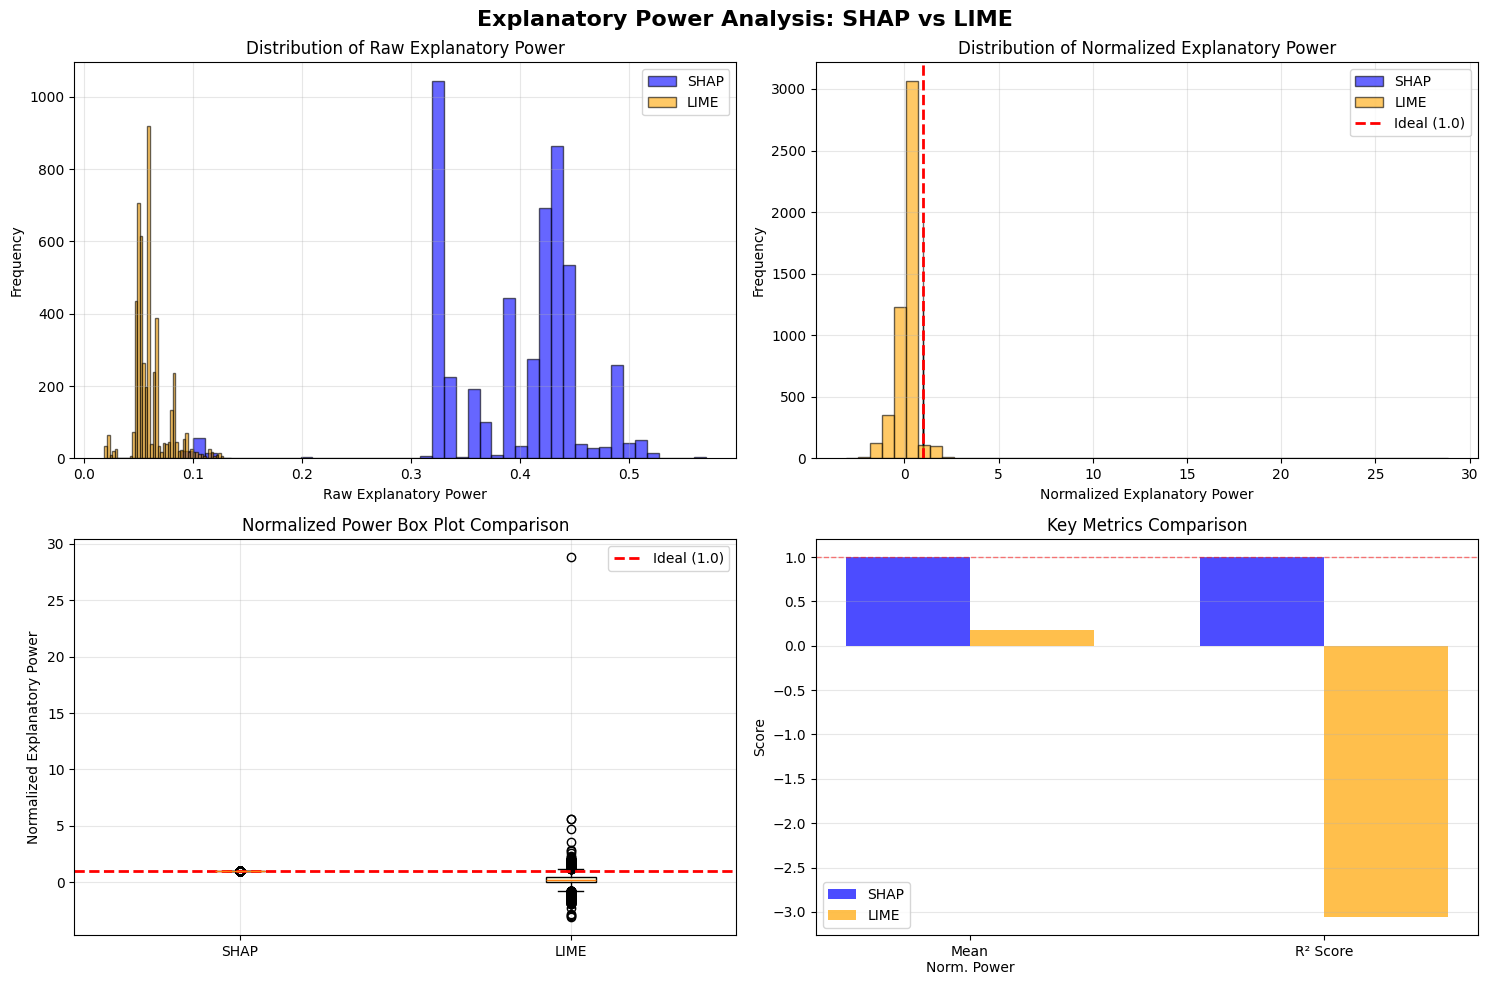

✓ Visualizations created successfully

EXPLANATORY POWER EVALUATION COMPLETE


In [ ]:
import sys
import importlib
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/ibibers/XAI_Evalation_For_IDS_datasets/XAI_Evaluation_Metrices')
import Explanatory_Power
importlib.reload(Explanatory_Power)
from Explanatory_Power import XAIExplanatoryPowerEvaluator

ep_evaluator = XAIExplanatoryPowerEvaluator(model=xgb_model, n_jobs=-1, random_state=42)

print("=" * 80)
print("EVALUATING EXPLANATORY POWER")
print("=" * 80)

print("\n--- SHAP Explanatory Power ---")



shap_results_predicted = ep_evaluator.evaluate(
    explainer=Shap_explainer,
    X=X_test.head(5000), 
    method='shap',
    normalization='output',  
    class_idx=None 
)

print("\nSHAP Results (Predicted Classes):")
print(f"  Mean Raw Power: {shap_results_predicted['mean_raw_power']:.4f}")
print(f"  Std Raw Power: {shap_results_predicted['std_raw_power']:.4f}")
print(f"  Min Raw Power: {shap_results_predicted['min_raw_power']:.4f}")
print(f"  Max Raw Power: {shap_results_predicted['max_raw_power']:.4f}")
print(f"\n  Mean Normalized Power: {shap_results_predicted['mean_normalized_power']:.4f}")
print(f"  Std Normalized Power: {shap_results_predicted['std_normalized_power']:.4f}")
print(f"  R² Score: {shap_results_predicted['r2_score']:.4f}")


if shap_results_predicted['r2_score'] > 0.8:
    print("  Excellent: SHAP explanations highly correlate with model outputs")
elif shap_results_predicted['r2_score'] > 0.6:
    print("   Good: SHAP explanations reasonably correlate with model outputs")
else:
    print("   Warning: SHAP explanations may not fully capture model behavior")


if 0.8 <= shap_results_predicted['mean_normalized_power'] <= 1.2:
    print("  Excellent: Explanations fully account for model outputs")
elif 0.6 <= shap_results_predicted['mean_normalized_power'] <= 1.4:
    print("   Good: Explanations mostly account for model outputs")
else:
    print("   Warning: Explanations may over/under-explain model outputs")



print("\n" + "=" * 80)
print("--- LIME Explanatory Power ---")

print("=== LIME EXPLAINER DIAGNOSTICS ===")
print(f"Explainer type: {type(lime_explianer)}")
print(f"Explainer mode: {lime_explianer.mode}")

test_instance = X_test.iloc[0].values
if xgb_model.predict_proba is not None:
    pred_fn = lambda x: xgb_model.predict_proba(pd.DataFrame(x, columns=X_test.columns))
    single_prob = pred_fn([test_instance])
    print(f"Single prediction probabilities shape: {single_prob.shape}")
    print(f"Single prediction probabilities: {single_prob[0]}")
    

exp = lime_explianer.explain_instance(
    test_instance.astype(np.double),
    pred_fn,
    num_features=10,
    labels=[xgb_model.predict([test_instance])[0]]
)

weights = dict(exp.as_list(label=xgb_model.predict([test_instance])[0]))
print(f"LIME weights for single instance: {sum(abs(v) for v in weights.values()):.4f}")
print(f"Model output for single instance: {single_prob[0][xgb_model.predict([test_instance])[0]]:.4f}")


lime_results = ep_evaluator.evaluate(
    explainer=lime_explianer,
    X=X_test.head(5000), 
    method='lime',
    normalization='output',  
    class_idx=None  
)

print("\nLIME Results:")
print(f"  Mean Raw Power: {lime_results['mean_raw_power']:.4f}")
print(f"  Std Raw Power: {lime_results['std_raw_power']:.4f}")
print(f"  Min Raw Power: {lime_results['min_raw_power']:.4f}")
print(f"  Max Raw Power: {lime_results['max_raw_power']:.4f}")
print(f"\n  Mean Normalized Power: {lime_results['mean_normalized_power']:.4f}")
print(f"  Std Normalized Power: {lime_results['std_normalized_power']:.4f}")
print(f"  R² Score: {lime_results['r2_score']:.4f}")

if lime_results['r2_score'] > 0.8:
    print("   Excellent: LIME explanations highly correlate with model outputs")
elif lime_results['r2_score'] > 0.6:
    print("   Good: LIME explanations reasonably correlate with model outputs")
else:
    print("   Warning: LIME explanations may not fully capture model behavior")


if 0.8 <= lime_results['mean_normalized_power'] <= 1.2:
    print("   Excellent: Explanations fully account for model outputs")
elif 0.6 <= lime_results['mean_normalized_power'] <= 1.4:
    print("   Good: Explanations mostly account for model outputs")
else:
    print("   Warning: Explanations may over/under-explain model outputs")


print("\n" + "=" * 80)
print("--- SHAP vs LIME Comparison ---")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Metric': ['Mean Raw Power', 'Mean Normalized Power', 'R² Score', 'Std Raw Power'],
    'SHAP': [
        shap_results_predicted['mean_raw_power'],
        shap_results_predicted['mean_normalized_power'],
        shap_results_predicted['r2_score'],
        shap_results_predicted['std_raw_power']
    ],
    'LIME': [
        lime_results['mean_raw_power'],
        lime_results['mean_normalized_power'],
        lime_results['r2_score'],
        lime_results['std_raw_power']
    ]
})

print(comparison_df.to_string(index=False))


print("\n--- Overall Assessment ---")
shap_score = (shap_results_predicted['r2_score'] + 
              (1 if 0.8 <= shap_results_predicted['mean_normalized_power'] <= 1.2 else 0.5))
lime_score = (lime_results['r2_score'] + 
              (1 if 0.8 <= lime_results['mean_normalized_power'] <= 1.2 else 0.5))

if shap_score > lime_score:
    print(" SHAP has better explanatory power for this model")
elif lime_score > shap_score:
    print("LIME has better explanatory power for this model")
else:
    print(" SHAP and LIME have similar explanatory power")


print("\n" + "=" * 80)
print("--- Distribution Analysis ---")
print("=" * 80)


print("\nSHAP Power Distribution Percentiles:")
shap_percentiles = np.percentile(shap_results_predicted['raw_powers'], [25, 50, 75, 90, 95])
print(f"  25th percentile: {shap_percentiles[0]:.4f}")
print(f"  50th percentile (median): {shap_percentiles[1]:.4f}")
print(f"  75th percentile: {shap_percentiles[2]:.4f}")
print(f"  90th percentile: {shap_percentiles[3]:.4f}")
print(f"  95th percentile: {shap_percentiles[4]:.4f}")

print("\nLIME Power Distribution Percentiles:")
lime_percentiles = np.percentile(lime_results['raw_powers'], [25, 50, 75, 90, 95])
print(f"  25th percentile: {lime_percentiles[0]:.4f}")
print(f"  50th percentile (median): {lime_percentiles[1]:.4f}")
print(f"  75th percentile: {lime_percentiles[2]:.4f}")
print(f"  90th percentile: {lime_percentiles[3]:.4f}")
print(f"  95th percentile: {lime_percentiles[4]:.4f}")


print("\n" + "=" * 80)
print("--- Creating Visualizations ---")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Explanatory Power Analysis: SHAP vs LIME', fontsize=16, fontweight='bold')

axes[0, 0].hist(shap_results_predicted['raw_powers'], bins=50, alpha=0.6, label='SHAP', color='blue', edgecolor='black')
axes[0, 0].hist(lime_results['raw_powers'], bins=50, alpha=0.6, label='LIME', color='orange', edgecolor='black')
axes[0, 0].set_xlabel('Raw Explanatory Power')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Raw Explanatory Power')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].hist(shap_results_predicted['normalized_powers'], bins=50, alpha=0.6, label='SHAP', color='blue', edgecolor='black')
axes[0, 1].hist(lime_results['normalized_powers'], bins=50, alpha=0.6, label='LIME', color='orange', edgecolor='black')
axes[0, 1].set_xlabel('Normalized Explanatory Power')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Normalized Explanatory Power')
axes[0, 1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Ideal (1.0)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


box_data = [shap_results_predicted['normalized_powers'], lime_results['normalized_powers']]
bp = axes[1, 0].boxplot(box_data, labels=['SHAP', 'LIME'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightyellow')
axes[1, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Ideal (1.0)')
axes[1, 0].set_ylabel('Normalized Explanatory Power')
axes[1, 0].set_title('Normalized Power Box Plot Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


metrics_names = ['Mean\nNorm. Power', 'R² Score']
shap_metrics = [shap_results_predicted['mean_normalized_power'], shap_results_predicted['r2_score']]
lime_metrics = [lime_results['mean_normalized_power'], lime_results['r2_score']]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x - width/2, shap_metrics, width, label='SHAP', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, lime_metrics, width, label='LIME', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Key Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("✓ Visualizations created successfully")
print("\n" + "=" * 80)
print("EXPLANATORY POWER EVALUATION COMPLETE")
print("=" * 80)

In [ ]:
actionable_features = [col for col in X_test.columns if any(x in col.lower() for x in 
                      ['rate', 'flag', 'port', 'protocol', 'count', 'packet', 'byte'])]

print(f"Number of total features: {len(X_test.columns)}")
print(f"Number of actionable features: {len(actionable_features)}")
print("Sample of actionable features:", actionable_features[:76])

Number of total features: 76
Number of actionable features: 45
Sample of actionable features: ['Destination Port', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Pac

==== ACTIONABILITY SUMMARY ====
LIME Actionability Mean Score: 0.7674218647499129
SHAP Actionability Mean Score: 0.9395514558952267
==== Actionability Summary Table ====


,Method,Mean,Std,Median,N
0,LIME,0.767422,0.077322,0.768594,1000
1,SHAP,0.939551,0.118104,0.972086,1000



==== Comparison (LIME vs SHAP) ====


,Paired t-stat,Paired p-value,Cohen's d (paired),Pearson r,Pearson p-value,Significant (alpha=0.05)
0,-36.960,3.71e-189,-1.169,-0.096,2.26e-03,Yes


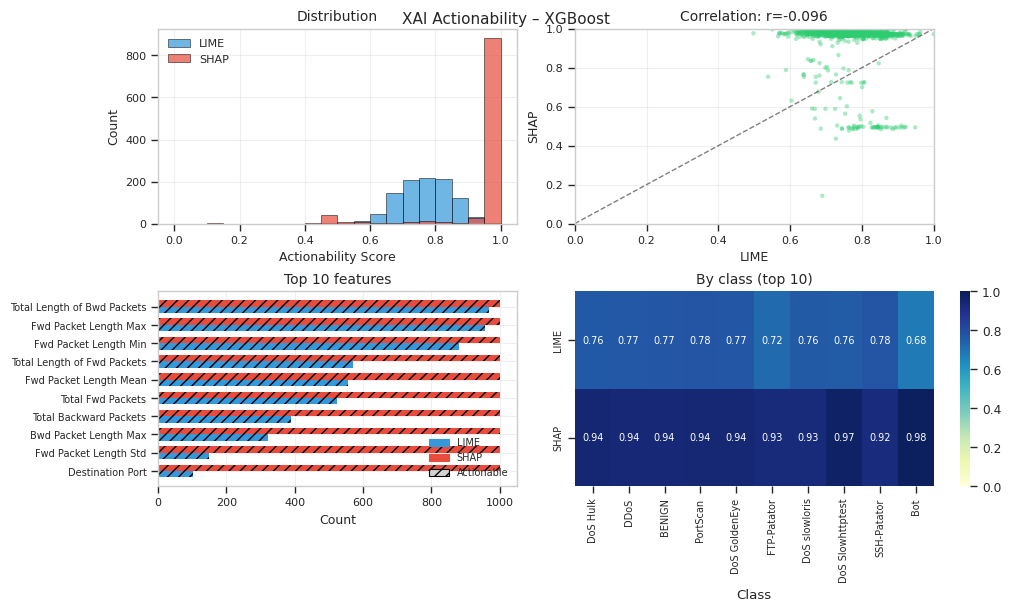

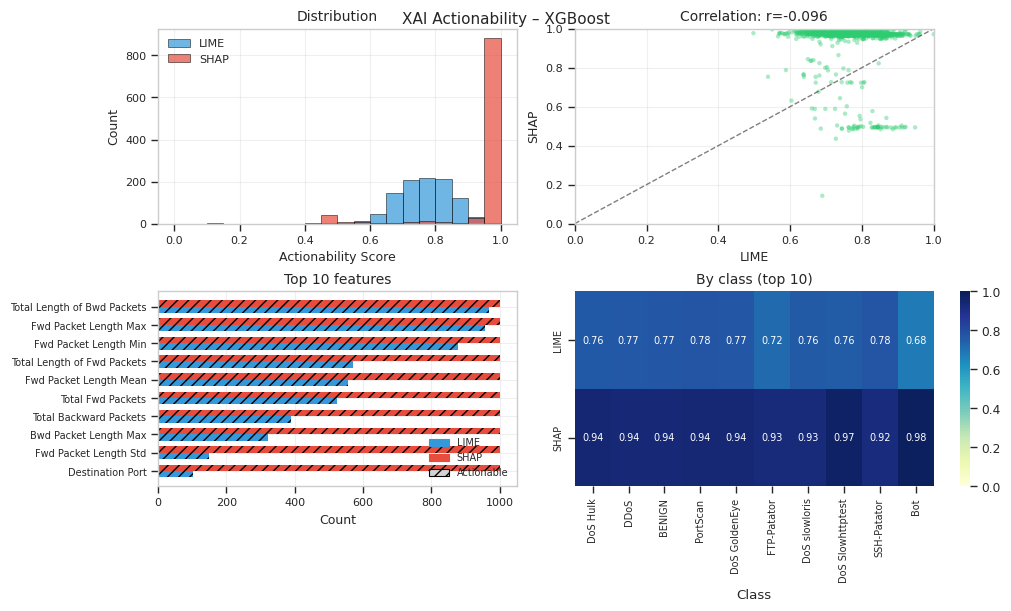

In [ ]:
import sys
import importlib
import pandas as pd
from regex import F
from sklearn.tree import DecisionTreeClassifier
from sympy import false
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sys.path.append('/home/ibibers/XAI_Evalation_For_IDS_datasets/XAI_Evaluation_Metrices')
import Actionability
importlib.reload(Actionability)
import warnings
warnings.filterwarnings('ignore')


actionability_evaluator = Actionability.XAIActionabilityEvaluator(xgb_model)


def get_detailed_actionability_results(evaluator, explainer, X, method, actionable_features, 
                                     top_k=15, sample_size=None, random_state=42):
    results = evaluator.evaluate_actionability(
        explainer=explainer,
        X=X,
        method=method,
        actionable_features=actionable_features,
        top_k=top_k,
        verbose=False,
        sample_size=sample_size,
        random_state=random_state,
        return_details=True  
    )
    return results


lime_results = get_detailed_actionability_results(
    evaluator=actionability_evaluator,
    explainer=lime_explianer,
    X=X_test,
    method='lime',
    actionable_features=actionable_features,
    top_k=15,
    sample_size=1000  
)

shap_results = get_detailed_actionability_results(
    evaluator=actionability_evaluator,
    explainer=Shap_explainer,
    X=X_test,
    method='shap',
    actionable_features=actionable_features,
    top_k=15,
    sample_size=1000 
)


y_pred_encoded = xgb_model.predict(X_test)
class_names = le.classes_  

print("==== ACTIONABILITY SUMMARY ====")
print("LIME Actionability Mean Score:", lime_results['mean_score'])
print("SHAP Actionability Mean Score:", shap_results['mean_score'])


lime_scores = np.asarray(lime_results['instance_scores'], dtype=float)
shap_scores = np.asarray(shap_results['instance_scores'], dtype=float)
n = min(len(lime_scores), len(shap_scores))
lime_scores = lime_scores[:n]
shap_scores = shap_scores[:n]

def summarize(arr):
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr, ddof=1)),
        "median": float(np.median(arr)),
        "n": int(len(arr))
    }

lime_summary = summarize(lime_scores)
shap_summary = summarize(shap_scores)

t_stat, p_ttest = stats.ttest_rel(lime_scores, shap_scores, nan_policy='omit')
diff = lime_scores - shap_scores
cohens_d = float(np.mean(diff) / (np.std(diff, ddof=1) + 1e-12))


r_corr, p_corr = stats.pearsonr(lime_scores, shap_scores)

# 5) Build a static summary table
summary_table = pd.DataFrame([
    {"Method": "LIME", "Mean": lime_summary["mean"], "Std": lime_summary["std"], "Median": lime_summary["median"], "N": lime_summary["n"]},
    {"Method": "SHAP", "Mean": shap_summary["mean"], "Std": shap_summary["std"], "Median": shap_summary["median"], "N": shap_summary["n"]},
])

comparison_table = pd.DataFrame([{
    "Paired t-stat": float(t_stat),
    "Paired p-value": float(p_ttest),
    "Cohen's d (paired)": cohens_d,
    "Pearson r": float(r_corr),
    "Pearson p-value": float(p_corr),
    "Significant (alpha=0.05)": "Yes" if p_ttest < 0.05 else "No"
}])

print("==== Actionability Summary Table ====")
display(summary_table.style.format({"Mean": "{:.6f}", "Std": "{:.6f}", "Median": "{:.6f}"}))
print("\n==== Comparison (LIME vs SHAP) ====")
display(comparison_table.style.format({"Paired p-value": "{:.2e}", "Pearson p-value": "{:.2e}", "Paired t-stat": "{:.3f}", "Pearson r": "{:.3f}", "Cohen's d (paired)": "{:.3f}"}))


Actionability.XAIActionabilityEvaluator.visualize_actionability_results(
    lime_results, shap_results, actionable_features, model_name="XGBoost",     y_pred=y_pred_encoded,
    class_names=class_names
)



Running Complete Evaluation Pipeline for XGBoost CICIDS2017 Dataset


--- Evaluating LIME ---
  Evaluating top_k=5...
  Evaluating top_k=10...
  Evaluating top_k=15...
  Evaluating top_k=20...

--- Evaluating SHAP ---
  Evaluating top_k=5...
  Evaluating top_k=10...
  Evaluating top_k=15...
  Evaluating top_k=20...

--- Running Statistical Validation (n=1000) ---
  [Info] Requested validation n=1000 > available 20; using n=20.
  Validating LIME...
  Validating SHAP...

Running Complete Evaluation Pipeline for XGBoost CICIDS2017 Dataset


--- Evaluating LIME ---
  Evaluating top_k=5...
  Evaluating top_k=10...
  Evaluating top_k=15...
  Evaluating top_k=20...

--- Evaluating SHAP ---
  Evaluating top_k=5...
  Evaluating top_k=10...
  Evaluating top_k=15...
  Evaluating top_k=20...

--- Running Statistical Validation (n=1000) ---
  [Info] Requested validation n=1000 > available 50; using n=50.
  Validating LIME...
  Validating SHAP...

Running Complete Evaluation Pipeline for XGBoost CI

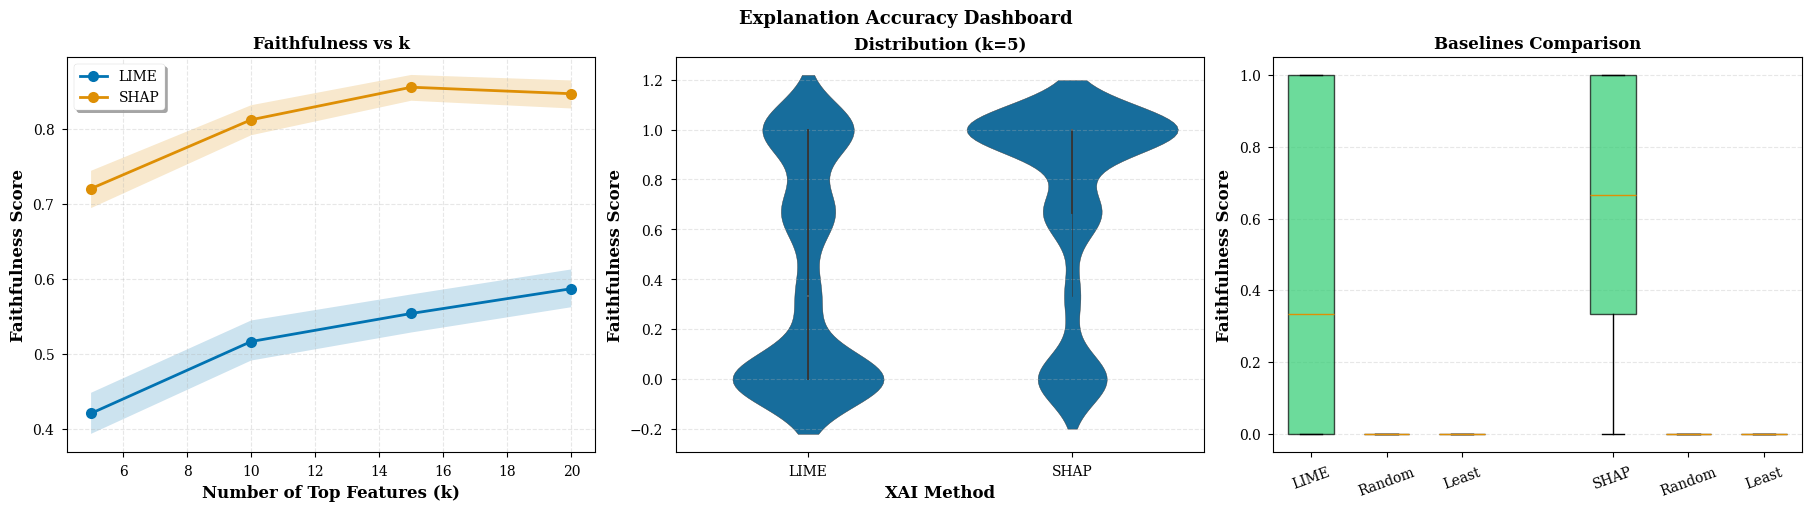


--- Generating Summary Report ---
  Saved: Exp_Acc_CIC_Xgboost_results/summary_report.txt

DT COMPLETE! All results saved to ./results/

Generated files:
  - tables/main_results.csv & .tex
  - tables/validation.csv & .tex
  - figures/faithfulness_by_k.pdf & .png
  - figures/distribution_comparison.pdf & .png
  - figures/baseline_comparison.pdf & .png
  - summary_report.txt
SHAP Faithfulness : 0.835
LIME Faithfulness : 0.465


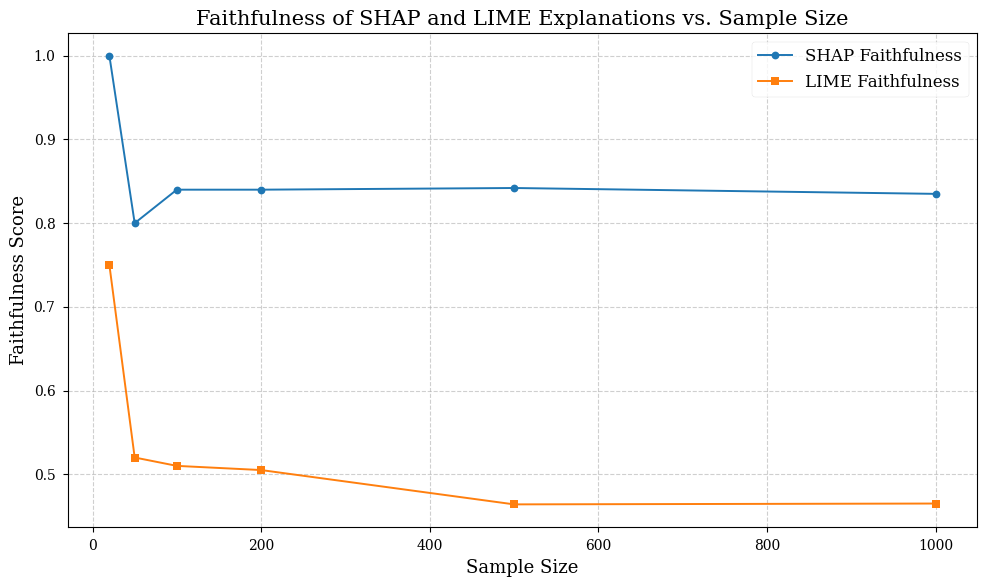

   instance_idx  faithfulness_score  \
0             0                 1.0   
1             1                 1.0   
2             2                 1.0   
3             3                 1.0   
4             4                 1.0   

                                    top_features_idx  \
0  [5, 3, 4, 66, 39, 14, 15, 0, 1, 45, 22, 67, 11...   
1  [5, 3, 4, 66, 39, 14, 15, 0, 1, 45, 22, 67, 11...   
2  [65, 72, 5, 50, 64, 33, 1, 44, 25, 32, 24, 6, ...   
3  [5, 4, 3, 66, 15, 39, 22, 14, 41, 1, 0, 32, 67...   
4  [1, 0, 67, 44, 2, 4, 64, 34, 12, 11, 8, 65, 14...   

                                  top_features_names  \
0  [Total Length of Bwd Packets, Total Backward P...   
1  [Total Length of Bwd Packets, Total Backward P...   
2  [Init_Win_bytes_backward, Idle Mean, Total Len...   
3  [Total Length of Bwd Packets, Total Length of ...   
4  [Flow Duration, Destination Port, min_seg_size...   

                                   importance_values  original_pred  
0  [0.348207265138626

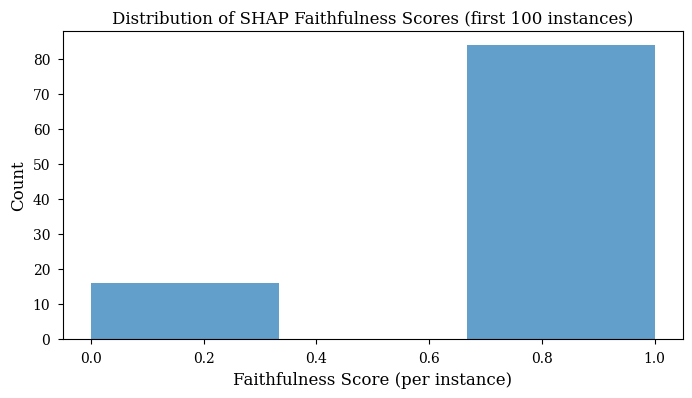

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import sys
import importlib

sys.path.append('/home/ibibers/XAI_Evalation_For_IDS_datasets/XAI_Evaluation_Metrices')
import Accuracy_of_Explanation
importlib.reload(Accuracy_of_Explanation)

from Accuracy_of_Explanation import XAIExplanationAccuracyEvaluator , PaperResultsGenerator

evaluator = XAIExplanationAccuracyEvaluator(
    model=xgb_model,
    perturbation_strategy='median',  
    task='classification'
)



sample_sizes = [20, 50, 100, 200, 500, 1000]
faithfulness_shap_scores = []
faithfulness_lime_scores = []

generator = PaperResultsGenerator(output_dir="./Exp_Acc_CIC_Xgboost_results")
for size in sample_sizes:
    X_sample = X_test.iloc[:size]
    faithfulness_shap = evaluator.evaluate(
        explainer=Shap_explainer,
        X=X_sample,
        method='shap',
        top_k=15,
        return_details=False
    )
    faithfulness_lime = evaluator.evaluate(
        explainer=lime_explianer,
        X=X_sample,
        method='lime',
        top_k=15,
        return_details=False
    )
    faithfulness_shap_scores.append(faithfulness_shap)
    faithfulness_lime_scores.append(faithfulness_lime)

    results = generator.run_complete_evaluation(
        model=xgb_model,
        X=X_sample,
        explainer_lime=lime_explianer,
        explainer_shap=Shap_explainer,
        dataset_name="XGBoost CICIDS2017 Dataset",  
        top_k_values=[5 , 10 , 15 , 20 ],
        n_samples_validation=1000
    )

# Generate all outputs
generator.generate_tables(results)
generator.generate_figures(results)
generator.generate_summary_report(results)

print("\n" + "="*70)
print("DT COMPLETE! All results saved to ./results/")
print("="*70)
print("\nGenerated files:")
print("  - tables/main_results.csv & .tex")
print("  - tables/validation.csv & .tex")
print("  - figures/faithfulness_by_k.pdf & .png")
print("  - figures/distribution_comparison.pdf & .png")
print("  - figures/baseline_comparison.pdf & .png")
print("  - summary_report.txt")

print(f"SHAP Faithfulness :", faithfulness_shap)
print(f"LIME Faithfulness :", faithfulness_lime)



plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, faithfulness_shap_scores, marker='o', label='SHAP Faithfulness', color='tab:blue')
plt.plot(sample_sizes, faithfulness_lime_scores, marker='s', label='LIME Faithfulness', color='tab:orange')
plt.xlabel('Sample Size', fontsize=13)
plt.ylabel('Faithfulness Score', fontsize=13)
plt.title('Faithfulness of SHAP and LIME Explanations vs. Sample Size', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





details = evaluator.evaluate(
    explainer=Shap_explainer,
    X=X_test.iloc[:100],
    method='shap',
    top_k=15,
    return_details=True
)
import pandas as pd
details_df = pd.DataFrame(details['details'])
print(details_df.head())


plt.figure(figsize=(8, 4))
plt.hist(details_df['faithfulness_score'], bins=3, color='tab:blue', alpha=0.7)
plt.xlabel('Faithfulness Score (per instance)')
plt.ylabel('Count')
plt.title('Distribution of SHAP Faithfulness Scores (first 100 instances)')
plt.show()
